<a href="https://colab.research.google.com/github/Reznic/SVM-Project/blob/main/maman13_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Maman 13
====================
Tal Reznik
318252095

# 4) 
## Part A
**Implementation of SVM, using SMO algorithm**




In [1]:
import numpy as np
from functools import lru_cache, partial
from time import time


class SVM:
    """Support Vector Machine model, implemented using the SMO algorithm.
    
    C - regularization parameter
    kernel - function to calculate phi(X)*phi(Y)
        Default - simple dot-product polynomial kernel.
    Usage example:
        model = SVM(c=100, kernel=np.dot)
        model.fit(Training_Data, Training_Labels)
        model.predict(sample)

    Evaluation of the model:
        model.evaluate_model(Test_Data, Test_Labels)
        (returns the error percentage)
    """
    def __init__(self, c, kernel=np.dot, accuracy=0.001):
        self.c = c
        self.epsilon = accuracy
        self.K = kernel
        self.dim = None
        self.alpha = None
        self.X = None
        self.Y = None
        self.N = None
        self.b = None

    def predict(self, X):
        """Predict the label of given feature vectors - X.

        X can be either a single vector - features of sample to predict, 
        or a matrix - list of samples to predict.
        The model must first be trained (see SVM.fit).
        """
        return np.sign(self._f(X))

    def evaluate_model(self, data, labels):
        """Predict samples in the given dataset, and return the 
        misclasification error ratio.
        """
        predicted_labels = self.predict(data)
        # count misclassified labels
        error_count = sum(abs(predicted_labels - labels) / 2)
        error_ratio = error_count / len(labels)
        return error_ratio
        
    def fit(self, X, Y):
        """Train the SVM model, on a list of example vectors and their labels.

        X - Matrix of feature vector examples to train on.
        Y - Vector of corresponding labels of the training examples.
        """
        if len(X) != len(Y):
            raise ValueError(f"Mismatching data size of X and Y: "
                             f"{len(X)} and {len(Y)}")
        self.X = X
        self.Y = Y
        self.N = len(self.X)
        self.dim = len(self.X[0])

        # Initialize model state
        self.alpha = np.zeros(self.N)
        self.b = 0
        # Save timestamp of last model update, for caching purposes
        self.alpha_update_ts = time()

        # Try to choose two alpha's at a time, and optimize them.
        # Start with trying all alpha's as alpha-2, and then switch to
        # picking non-bounded alphas, until all could not be optimized.
        # Then, try again all possible alpha's, and so on, 
        # until no significant alpha update could be made.
        alpha_changed = False
        examine_all = True

        while(alpha_changed or examine_all):
            alpha_changed = False
            if examine_all:
                # Loop over all possible alphas
                for i in range(self.N):
                    alpha_changed = self._smo_examine_example(i)
            else:
                # Loop over non-bounded alphas
                for i in range(self.N):
                    if self.alpha[i] > 0 and self.alpha[i] < self.c:
                        alpha_changed = self._smo_examine_example(i)

            if examine_all == True:
                examine_all = False
            elif not alpha_changed:
                examine_all = True

    def _f(self, x):
        """Calculate the model's prediction on given sample - x."""
        if self.alpha is None or self.b is None:
            raise ValueError("SVM model Not trained.")
        b = self.b
        a = self.alpha
        y = self.Y
        X = self.X
        K = self.K
        # calculate W*X + b
        return (y*a).T.dot(K(X, x.T)) + b

    def _obj_func(self, i2, alpha2):
        """Calculate the objective function of the dual problem, 
        with substitution of the given alpha in the alpha vectors.
        """
        a = self.alpha
        save_a2 = a[i2]
        a[i2] = alpha2
        result = (a*Y).T.dot(K(X, X.T)).dot(a*Y)
        a[12] = save_a2
        return result

    @lru_cache(maxsize=256)
    def _get_error(self, i, alpha_update_ts):
        """Calculate the error of a training sample in a given index - i.
        This method uses caching for optimization, and should be given 
        the timestamp of the last model state update, in order to discard
        cached results of old model states.
        """
        return self.Y[i] - self._f(self.X[i])

    def _smo_examine_example(self, i2):
        """Try to choose alpha-1 heuristically and call smo_step with a1 and a2.

        The Heuristic for choosing alpha 1, is to first try the non-bounded
        alpha's, and from them, try the alpha's which will yield the largest 
        update step for a2, if chosen. The step size of the update step:
        a2 = a2 + y2*(E1-E2)/eta
        is approximized by the nominator: |E1 - E2|.
        The non-bounded alphas are sorted according to their corresponding 
        step size approximation, and then tried out in that order. If None of 
        the tried alpha's lead to successful update, rest of alpha's are tried.
        """
        a = self.alpha
        # Error function, with caching
        E = partial(self._get_error, alpha_update_ts=self.alpha_update_ts)
        E2 = E(i2)
        # Sort non-bounded alpha's according to their step size aproximation.
        aprox_step_size = lambda i1: abs(E2 - E(i1))
        best_i1_list = [(aprox_step_size(i1), i1) for i1 in range(self.N)
                        if a[i1] > 0 and a[i1] < self.c]
        best_i1_list.sort(reverse=True)

        # Loop over non-bounded a1's, with the largest step size
        for _, i1 in best_i1_list:
            if self._smo_step(i1, i2):
                return True
        
        # Loop over rest of bouned a1's
        for i1 in range(self.N):
            if a[i1] == 0 or a[i1] >= self.c:
                if self._smo_step(i1, i2):
                    return True
        return False

    def _smo_step(self, i1, i2):
        """Try to optimize two alpha parameters - at the given indices i1, i2"""
        if i1 == i2:
            return False

        a = self.alpha
        Y = self.Y
        X = self.X
        K = self.K
        eps = self.epsilon
        # Error function, with caching
        E = partial(self._get_error, alpha_update_ts=self.alpha_update_ts)

        # Calculate constraints bounds on alpha-2
        if Y[i1] * Y[i2] == 1:
            L = max(0, a[i2] + a[i1] - self.c)
            H = min(self.c, a[i2] + a[i1])
        else:
            L = max(0, a[i2] - a[i1])
            H = min(self.c, self.c + a[i2] - a[i1])
            
        if L == H:
            return False

        # Calculate the optimal alpha-2, and clip it to fit the bounds
        K11 = K(X[i1], X[i1])
        K22 = K(X[i2], X[i2])
        K12 = K(X[i1], X[i2])
        eta = K11 + K22 - 2*K12

        if eta > 0:
            # Update step for alpha-2
            optimal_a2 = a[i2] + Y[i2] * (E(i2) - E(i1)) / eta
            # Clipping of alpha-2
            a2_clip = max(min(optimal_a2, H), L)
        else:
            # Alternative clipping under unusual circumstances
            Lobj = self._obj_func(i2, L)
            Hobj = self._obj_func(i2, H)
            if (Lobj < Hobj - eps):
                a2_clip = L
            elif (Lobj > Hobj + eps):
                a2_clip = H
            else:
                a2_clip = a[i2]

        # Check stop condition - insignificant alpha change
        delta_a2 = a[i2] - a2_clip
        if abs(delta_a2) < eps * (a[i2] + a2_clip + eps):
            return False

        # Update alpha-1 and alpha-2
        a[i1] =  a[i1] + Y[i1] * Y[i2] * delta_a2
        a[i2] = a2_clip

        # Find a non-bounded example
        s=0
        for i in range(self.N):
            if a[i] > 0 and a[i] < self.c:
                s = i

        # Update the bias
        self.b = Y[s] - (a * Y).dot(K(X, X[s]))

        # Change model update-timestamp (to clear the cache)
        self.alpha_update_ts = time()

        return True


# Part B
## (a) 
**Scatter plot of the Iris dataset**

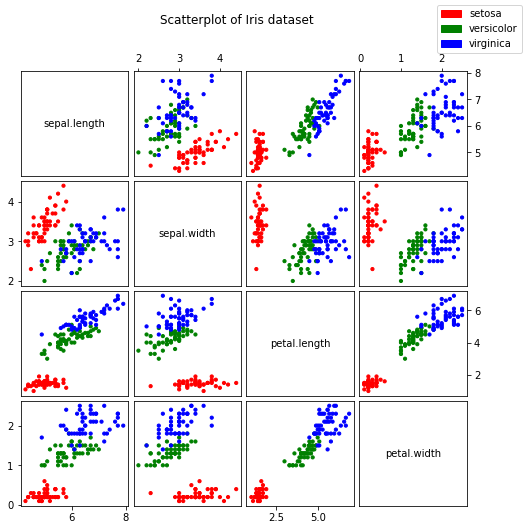

In [2]:
from sklearn import datasets
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def scatterplot_matrix(data, names, **kwargs):
    """Plots a scatterplot matrix of subplots.  Each row of "data" is plotted
    against other rows, resulting in a nrows by nrows grid of subplots with the
    diagonal subplots labeled with "names".  Additional keyword arguments are
    passed on to matplotlib's "plot" command. Returns the matplotlib figure
    object containg the subplot grid."""
    numvars, numdata = data.shape
    fig, axes = plt.subplots(nrows=numvars, ncols=numvars, figsize=(8,8))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    for ax in axes.flat:
        # Hide all ticks and labels
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        # Set up ticks only on one side for the "edge" subplots...
        if ax.is_first_col():
            ax.yaxis.set_ticks_position('left')
        if ax.is_last_col():
            ax.yaxis.set_ticks_position('right')
        if ax.is_first_row():
            ax.xaxis.set_ticks_position('top')
        if ax.is_last_row():
            ax.xaxis.set_ticks_position('bottom')

    # Plot the data.
    for i, j in zip(*np.triu_indices_from(axes, k=1)):
        for x, y in [(i,j), (j,i)]:
            axes[x,y].scatter(data[y], data[x], **kwargs)

    # Label the diagonal subplots...
    for i, label in enumerate(names):
        axes[i,i].annotate(label, (0.5, 0.5), xycoords='axes fraction',
                ha='center', va='center')

    # Turn on the proper x or y axes ticks.
    for i, j in zip(range(numvars), itertools.cycle((-1, 0))):
        axes[j,i].xaxis.set_visible(True)
        axes[i,j].yaxis.set_visible(True)

    return fig


iris = datasets.load_iris()
iris_data = iris["data"]
iris_lables= iris["target"]
color_to_lable = {0:"red", 1:"green", 2:"blue"}
colors = [color_to_lable[i] for i in iris_lables]

fig = scatterplot_matrix(iris_data.T, ['sepal.length', 'sepal.width', \
                                       'petal.length', 'petal.width'],
                         c=colors, s=10)
fig.suptitle('Scatterplot of Iris dataset')

patches = [mpatches.Patch(color=color_to_lable[i], 
                          label=iris["target_names"][i]) for i in [0,1,2]]
fig.legend(handles=patches, loc="upper right")
plt.show()

The "Iris setosa" species seems to be the most separable.

## (b)

**Splitting the Iris dataset**

In [3]:
from sklearn.model_selection import train_test_split

def split_dataset(data, labels, train_size, test_size, validation_size):
    """Split the give dataset into train, test and validation sets."""
    second_split_size = validation_size / (test_size + validation_size)
    X_train, X_nontrain, Y_train, Y_nontrain = \
        train_test_split(iris_data, iris_lables, train_size=train_size,
                         random_state=42)
    X_test, X_val, Y_test, Y_val = \
        train_test_split(X_nontrain, Y_nontrain, test_size=second_split_size,
                         random_state=42)
    return (X_train, Y_train), (X_test, Y_test), (X_val, Y_val)


train_set, test_set, validation_set = split_dataset(iris_data, iris_lables, 
                                                    train_size=0.6, 
                                                    test_size=0.2, 
                                                    validation_size=0.2)

train_X, train_Y = train_set
test_X, test_Y = test_set
validation_X, validation_Y = validation_set

**Multiclass SVM**

In [4]:
class OneVsAllSVM(SVM):
    """An SVM model that classifies one label class (unique_label), 
    from other label classes.
    Instances from the unique class, are labeld: 1, 
    and instances from other classes are labeled: -1
    """
    def __init__(self, unique_label, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.unique_label = unique_label

    def get_binary_labels(self, labels):
        """Generate new labels vector, by replacing the unique label with 1,
        and other labels with -1.
        """
        return [1 if label == self.unique_label else -1 
                for label in labels]

    def fit(self, X, Y):
        binary_labels = self.get_binary_labels(Y)
        super().fit(X, binary_labels)

    def evaluate_model(self, data, labels):
        binary_labels = self.get_binary_labels(labels)
        return super().evaluate_model(data, binary_labels)

    def get_table_of_confustion(self, data, labels):
        """Calculate predictions of the model on the given dataset, 
        and return the table of confusion - a 2x2 matrix.
        """
        confusion_table = np.zeros((2, 2))
        predictions = self.predict(data)
        for i in range(len(labels)):
            if predictions[i] == 1:
                predict_index = 0
            else:
                predict_index = 1
            if labels[i] == self.unique_label:
                actual_index = 0
            else:
                actual_index = 1
            confusion_table[actual_index][predict_index] += 1
        return confusion_table
    
    def get_sensitivity(self, data, labels):
        """Calculate predictions of the model on the given dataset, 
        and return the sensitivity value.
        """
        predictions = self.predict(data)
        true_positive = len([1 for i in range(len(labels)) 
                            if labels[i] == self.unique_label and 
                             predictions[i] == 1])
        false_negative = len([1 for i in range(len(labels))
                            if labels[i] == self.unique_label and 
                             predictions[i] == -1])
        return true_positive / (true_positive + false_negative)


class MulticlassSVM:
    """SVM classifier for multiple classes. Based on the One-Vs-All method.
    
    The labels of all the classes should be given in initialization (class_labels list).
    All the hyper-parameters: C, kernel and accuracy, can either be 
    specified differently for each 'sub-classifier' by passing a list of values,
    corresponding to the matching class in class_labels,
    Or, can be given as single value, with which all the sub-classifiers would
    be initialized identically.
    """
    def __init__(self, class_labels, c, kernel=np.dot, accuracy=0.001):
        self.class_labels = class_labels

        # Support option of giving same hyperparam for all SVM classifiers
        if type(c) is not list:
            c = [c] * len(class_labels)
        if type(kernel) is not list:
            kernel = [kernel] * len(class_labels)
        if type(accuracy) is not list:
            accuracy = [accuracy] * len(class_labels)

        # Init One-VS-All SVM model for each class
        self.classifiers = [OneVsAllSVM(label, c[i], kernel[i], accuracy[i]) 
                            for i, label in enumerate(class_labels)]

    def predict(self, x):
        """Predict the label of given feature vectors - x.

        The model must first be trained (see SVM.fit).
        """
        # Generate predictions of x, from every One-VS-All classifier
        predictions = [classifier._f(x) for classifier in self.classifiers]
        # Get the index of the classifier returning the maximal number -
        # The most "confident" classification, and return it's unique label.
        max_classifiers = np.argmax(np.array(predictions), axis=0)
        return [self.classifiers[i].unique_label for i in max_classifiers]
        
    def fit(self, X, Y):
        """Train the SVM model, on a list of example vectors and their labels.

        X - Matrix of feature vector examples to train on.
        Y - corresponding labels of the training examples.
        """
        for classifier in self.classifiers:
            classifier.fit(X, Y)

    def evaluate_model(self, data, labels):
        """Predict samples in the given dataset, and return the 
        misclasification ratio.
        """
        predicted_labels = self.predict(data)
        # count misclassified labels
        error_count = sum(abs(predicted_labels - labels) / 2)
        error_ratio = error_count / len(labels)
        return error_ratio

    def get_confusion_matrix(self, data, labels):
        """Calculate predictions of the model on the given dataset, 
        and return the confusion matrix.
        """
        confusion_matrix = np.zeros((len(self.class_labels), 
                                     len(self.class_labels)))
        predicted_labels = self.predict(data)
        for i in range(len(labels)):
            confusion_matrix[predicted_labels[i]][labels[i]] += 1

        return confusion_matrix

### Train and evaluate 3 SVM classifiers, for each iris species, with different C values

In [5]:
# Get the class labels in the Iris dataset
classes = np.unique(iris["target"])

# Grid-search for the hyper parameter C.
for C in [10, 5, 1, 0.9, 0.8, 0.5, 0.2, 0.1]:
    print(f"C={C}")
    iris_model = MulticlassSVM(class_labels=classes, c=C)
    iris_model.fit(train_X, train_Y)
    for classifier in iris_model.classifiers:
        class_name = iris['target_names'][classifier.unique_label]
        err = classifier.evaluate_model(validation_X, validation_Y)
        print(f"{class_name} classification error: {err}")

C=10
setosa classification error: 0.0
versicolor classification error: 0.3
virginica classification error: 0.03333333333333333
C=5
setosa classification error: 0.0
versicolor classification error: 0.3
virginica classification error: 0.03333333333333333
C=1
setosa classification error: 0.0
versicolor classification error: 0.3333333333333333
virginica classification error: 0.0
C=0.9
setosa classification error: 0.0
versicolor classification error: 0.43333333333333335
virginica classification error: 0.0
C=0.8
setosa classification error: 0.0
versicolor classification error: 0.36666666666666664
virginica classification error: 0.0
C=0.5
setosa classification error: 0.0
versicolor classification error: 0.4
virginica classification error: 0.0
C=0.2
setosa classification error: 0.0
versicolor classification error: 0.43333333333333335
virginica classification error: 0.1
C=0.1
setosa classification error: 0.0
versicolor classification error: 0.43333333333333335
virginica classification error: 0.

### C hyperparameter tuning, by validation set error comparison
| C   | Setosa validation Error | Virginica validation Error | Versicolor validation Error |
|-----|-------------------------|----------------------------|-------------------------|
| 10  | 0                       | 0.0333                         | 0.3                     |
| 5   | 0                       | 0.0333        | 0.3      |
| 1   | 0                       | 0                          | 0.333      |
| 0.9 | 0                       | 0                          | 0.4333                     |
| 0.8 | 0                       | 0                          | 0.366                     |
| 0.5 | 0                       | 0                          | 0.4      |
| 0.2 | 0                       | 0.1                          | 0.4333      |
| 0.1 | 0                       | 0                          | 0.4333      |

Conclusion: **C=1** yields the best validation-set error,
for all the 3 classifiers

### (c)
**Confusion Matrix**

Model accuracy on test set is: 0.9666666666666667


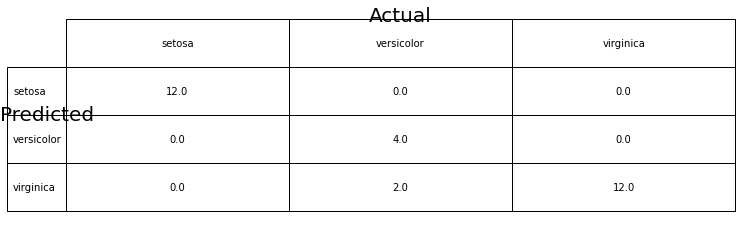

In [6]:
def plot_confusion_matrix(svm_model):
    """Train the SVM model on the Iris training set, evaluate it on the test set,
    print it's accuracy, and plot it's confusion matrix, on the test set."""
    svm_model.fit(train_X, train_Y)
    accuracy = 1 - svm_model.evaluate_model(test_X, test_Y)
    print(f"Model accuracy on test set is: {accuracy}")
    confusion_matrix = svm_model.get_confusion_matrix(test_X, test_Y)

    # Plotting the table
    table = plt.table(cellText=confusion_matrix, loc=(0,0), cellLoc='center', 
            rowLabels=iris['target_names'], colLabels=iris['target_names'])
    table.scale(2, 4)
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
    plt.annotate('Actual', (.5,1), ha="center", va="top", fontsize=20)
    plt.annotate('Predicted', (0,0.5), ha="left", va="center", fontsize=20, xycoords="figure fraction")
    for pos in ['right','top','bottom','left']:
        plt.gca().spines[pos].set_visible(False)

iris_classes = np.unique(iris["target"])
iris_model = MulticlassSVM(class_labels=iris_classes, c=1)
plot_confusion_matrix(iris_model)

Results:
Our model had only 2 misclassification out of 30 test-set samples
misclassified a versicolor as a virginica species.


# (d)
**Tables of confusion**

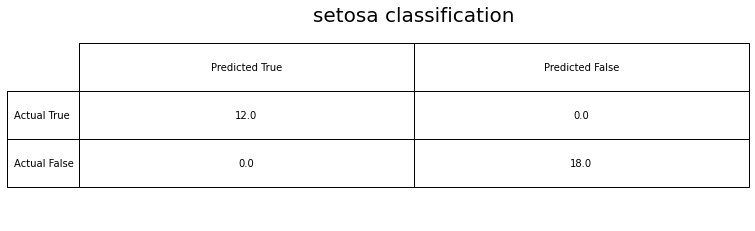

setosa classifier sensitivity is 1.0


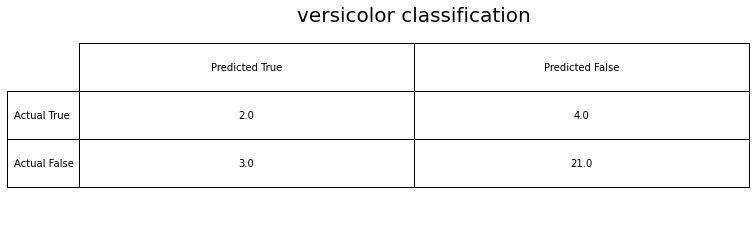

versicolor classifier sensitivity is 0.3333333333333333


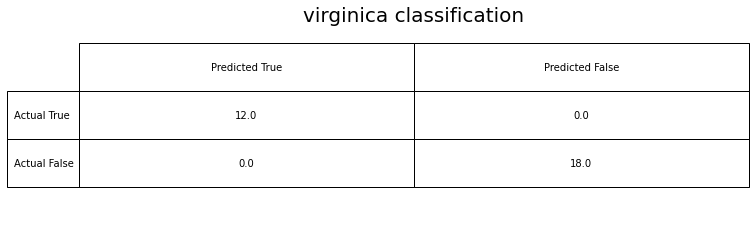

virginica classifier sensitivity is 1.0


In [7]:
def plot_tables_of_confusion(svm_model):
    """Plot the table of confusion for each sub-classifier of the multiclass svm model."""
    for classifier in svm_model.classifiers:
        confusion_table = classifier.get_table_of_confustion(test_X, test_Y)
        class_name = iris['target_names'][classifier.unique_label]
        # Plotting the table
        table = plt.table(cellText=confusion_table, loc=(0,0), cellLoc='center', 
                rowLabels=["Actual True", "Actual False"], 
                colLabels=["Predicted True", "Predicted False"])
        table.scale(2, 4)
        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
        plt.annotate(f"{class_name} classification", (.5,1), ha="center", va="top", fontsize=20)
        for pos in ['right','top','bottom','left']:
            plt.gca().spines[pos].set_visible(False)
        plt.show()

        # Print sensitivity
        sensitivity = classifier.get_sensitivity(test_X, test_Y)
        print(f"{class_name} classifier sensitivity is {sensitivity}")

plot_tables_of_confusion(iris_model)

The sensitivity of Setosa and virginica classifiers is excelent.
The sensitivity of Versicolor classifier is poor.

The Setosa species seems to be linearly separable from the other species,
while the Virginica and Versicolor species are not prefectly linaerly separable.


---



# (e)
# **RBF Kernel**



In [8]:
GAMMA = 1

def RBF(X, Y):
    if X.ndim > 1 and Y.ndim > 1:
        # Batch mode - Y is a matrix of multiple samples to predict
        return np.exp(-GAMMA * np.linalg.norm(X - np.stack([Y.T]*len(X), axis=1), axis=2)**2).T
    else:
        return np.exp(-GAMMA * np.linalg.norm(X - Y.T, axis=X.ndim-1)**2)

## Gamma hyperparameter tuning, by validation set error comparison

In [9]:
classes = np.unique(iris["target"])
C=1
print(f"C={C}")

# Grid-search for the hyper parameter Gamma.
for gamma in [10, 5, 1, 0.5, 0.3]:
    GAMMA = gamma
    print(f"GAMMA={GAMMA}")
    iris_model = MulticlassSVM(class_labels=classes, c=C, kernel=RBF)
    iris_model.fit(train_X, train_Y)
    for classifier in iris_model.classifiers:
        class_name = iris['target_names'][classifier.unique_label]
        err = classifier.evaluate_model(validation_X, validation_Y)
        print(f"{class_name} classification error: {err}")
    print("\n")

C=1
GAMMA=10
setosa classification error: 0.1
versicolor classification error: 0.1
virginica classification error: 0.06666666666666667


GAMMA=5
setosa classification error: 0.0
versicolor classification error: 0.03333333333333333
virginica classification error: 0.03333333333333333


GAMMA=1
setosa classification error: 0.0
versicolor classification error: 0.0
virginica classification error: 0.0


GAMMA=0.5
setosa classification error: 0.0
versicolor classification error: 0.03333333333333333
virginica classification error: 0.0


GAMMA=0.3
setosa classification error: 0.0
versicolor classification error: 0.03333333333333333
virginica classification error: 0.0




| Gamma | Setosa validation Error | Virginica validation Error | Versic validation Error |
|-------|-------------------------|----------------------------|-------------------------|
| 10    | 0.1                     | 0.0666                     | 0.1                     |
| 5     | 0                       | 0.0333                     | 0.0333                  |
| 1     | 0                       | 0                          | 0                       |
| 0.5   | 0                       | 0                          | 0.0333                  |
| 0.3   | 0                       | 0                          | 0.0333                  |

Conclusion: **Gamma=1** yields the best validation-set error,
for all the 3 classifiers with the RBF Kernel

## Confusion Matrix of the model with RBF kernel

Model accuracy on test set is: 1.0


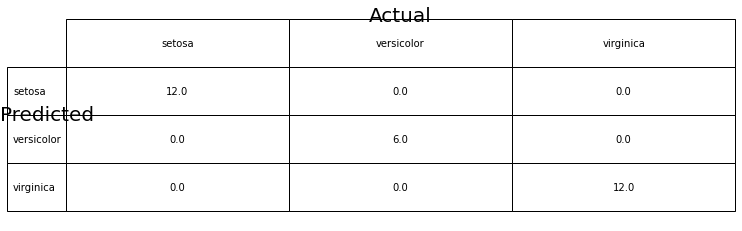

In [10]:
GAMMA = 1
iris_model_rbf_kernel = MulticlassSVM(class_labels=iris_classes, c=1, kernel=RBF)
plot_confusion_matrix(iris_model_rbf_kernel)

## Tables of confusion

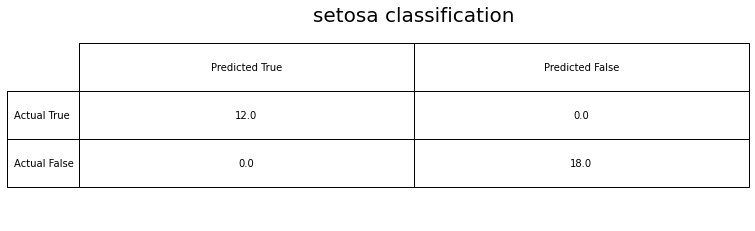

setosa classifier sensitivity is 1.0


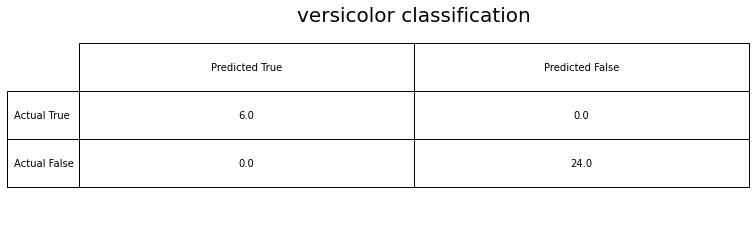

versicolor classifier sensitivity is 1.0


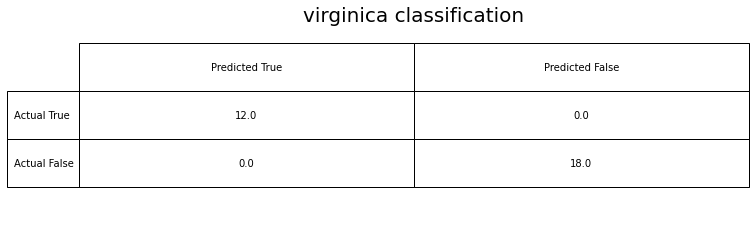

virginica classifier sensitivity is 1.0


In [11]:
plot_tables_of_confusion(iris_model_rbf_kernel)

The RBF kernel improved the model accuracy to 100%!
The model is now able to classify correctly the versicolor from the virginica species, Which were previously non-linearly separable (with polynomial kernel)